##  第一部分：資料分析

### 載入模組

In [580]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.options.mode.chained_assignment = None


### 了解資料

匯入資料

In [581]:
train = pd.read_csv("titanicTrain.csv")
test =  pd.read_csv ("titanicQuestion.csv")

In [582]:
test.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,3,NaN,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.7500,NaN,Q,NaN,NaN,NaN
1,3,NaN,"McCoy, Miss. Agnes",female,NaN,2,0,367226,23.2500,NaN,Q,16,NaN,NaN
2,3,NaN,"McCoy, Miss. Alicia",female,NaN,2,0,367226,23.2500,NaN,Q,16,NaN,NaN
3,3,NaN,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,NaN,Q,16,NaN,NaN
4,3,NaN,"McDermott, Miss. Brigdet Delia",female,NaN,0,0,330932,7.7875,NaN,Q,13,NaN,NaN


看看維度

In [583]:
train.shape

(1000, 14)

In [584]:
train.head(3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [585]:
test.shape

(309, 14)

看看有哪些欄位有空值

In [586]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
pclass       1000 non-null int64
survived     1000 non-null int64
name         1000 non-null object
sex          1000 non-null object
age          861 non-null float64
sibsp        1000 non-null int64
parch        1000 non-null int64
ticket       1000 non-null object
fare         1000 non-null float64
cabin        283 non-null object
embarked     998 non-null object
boat         417 non-null object
body         95 non-null float64
home.dest    742 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 109.5+ KB


In [587]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 14 columns):
pclass       309 non-null int64
survived     0 non-null float64
name         309 non-null object
sex          309 non-null object
age          185 non-null float64
sibsp        309 non-null int64
parch        309 non-null int64
ticket       309 non-null object
fare         308 non-null float64
cabin        12 non-null object
embarked     309 non-null object
boat         69 non-null object
body         26 non-null float64
home.dest    3 non-null object
dtypes: float64(4), int64(3), object(7)
memory usage: 33.9+ KB


將這兩個dataset放一起的原因是可一併分析處理，例如一些資料會有缺值情況需補值，以及不同資料分群時不用分開進行。不過最後在訓練學習之前，必須要記得將Test從Train dataset移出。

In [588]:
data = train.append(test)

由於使用append合併之後會造成index重複問題，因此要將index重新設定

In [589]:
data.reset_index(inplace=True, drop=True)

列出資料所有欄位名稱

In [590]:
data.shape

(1309, 14)

In [591]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1000 non-null float64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(4), int64(3), object(7)
memory usage: 143.2+ KB


In [592]:
data.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1000.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.423000,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.494283,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


### 資料探索(尋找與survived相關的feature) Feature Engineering & visualization

檢視非數值欄位

In [593]:
data.describe(include=['O'])

,name,sex,ticket,cabin,embarked,boat,home.dest
count,1309,1309,1309,295,1307,486,745
unique,1307,2,929,186,3,27,369
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S,13,"New York, NY"
freq,2,843,11,6,914,39,64


include=[‘O’]參數可針對Object類型欄位進行統計。執行後發現count=1309，unique=1307，Name欄位有兩筆是重複的名字。Sex欄位只有兩種Male/Female，其中以Male最多有843位。

視覺化

1.Sex Feature性別

Percentage of females who survived:78.17
Percentage of males who survived:21.14


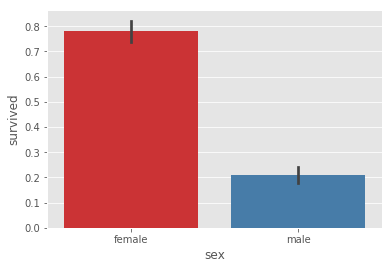

In [594]:
sns.barplot(x="sex",y="survived",data=data,palette='Set1')
print("Percentage of females who survived:%.2f"%(data["survived"][data["sex"]=='female'].value_counts(normalize=True)[1]*100))
print("Percentage of males who survived:%.2f"%(data["survived"][data["sex"]=='male'].value_counts(normalize=True)[1]*100))

In [595]:
data[['sex', 'survived']].groupby(['sex'], as_index=False).mean().sort_values(by='survived', ascending=False)

,sex,survived
0,female,0.781671
1,male,0.211447


2.Pclass Feature(社會階級)

女性存活率>男性

In [596]:
data.columns.values

array(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype=object)

Percentage of Pclass = 1 who survived:61.92
Percentage of Pclass = 2 who survived:42.96
Percentage of Pclass = 3 who survived:26.00


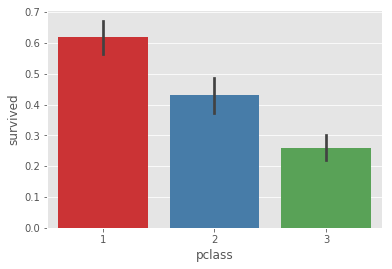

In [597]:
sns.barplot(x="pclass",y="survived",data=data,palette='Set1')
print("Percentage of Pclass = 1 who survived:%.2f"%(data["survived"][data["pclass"]==1].value_counts(normalize=True)[1]*100))
print("Percentage of Pclass = 2 who survived:%.2f"%(data["survived"][data["pclass"]==2].value_counts(normalize=True)[1]*100))
print("Percentage of Pclass = 3 who survived:%.2f"%(data["survived"][data["pclass"]==3].value_counts(normalize=True)[1]*100))

乘客社會階級越高 存活率越大

3.SibSp Feature and Parch Featrue(親屬間的關係)


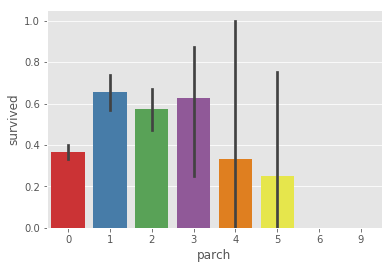

In [598]:
sns.barplot(x="parch",y="survived",data=data,palette='Set1')

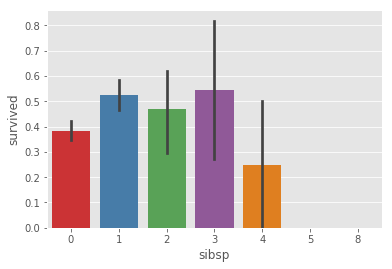

In [599]:
sns.barplot(x="sibsp",y="survived",data=data,palette='Set1')

將sibsp(配偶及兄弟姐妹數)與parch(父母與子女數)兩個變項合併成新的變項family_size(親屬)

In [600]:
data['family_size'] = data['parch'] + data['sibsp']

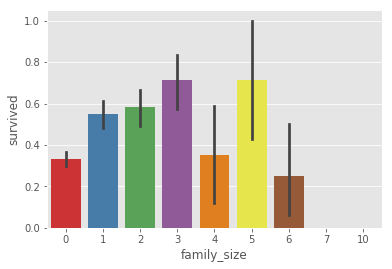

In [601]:
sns.barplot(x="family_size",y="survived",data=data,palette='Set1')

親屬數1~3人，存活率較高

4.Age Feature(年齡)

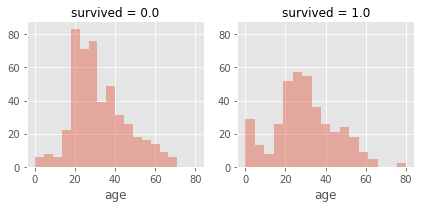

In [602]:
g = sns.FacetGrid(data, col='survived')
g.map(sns.distplot, 'age', kde=False)

年紀在0~20歲的存活率高於死亡率

5.Fare Feature(票價)

<bound method Grid.add_legend of <seaborn.axisgrid.FacetGrid object at 0x1a220c9978>>

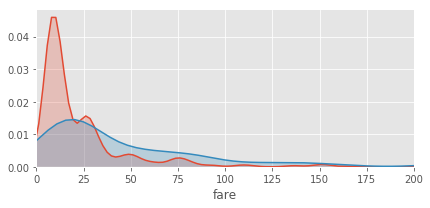

In [603]:
facet=sns.FacetGrid(data,hue="survived",aspect=2)
facet.map(sns.kdeplot,'fare',shade=True)
facet.set(xlim=(0,200))
facet.add_legend

購買越高的票價，存活率越高

6.Title Feature(將姓名的稱謂抓出來)

In [604]:
data['title1'] = data['name'].str.split(", ", expand=True)[1]

In [605]:
data['name'].str.split(", ", expand=True).head(3)

,0,1
0,Allen,Miss. Elisabeth Walton
1,Allison,Master. Hudson Trevor
2,Allison,Miss. Helen Loraine


In [606]:
data['title1'] = data['title1'].str.split(".", expand=True)[0]

In [607]:
data['title1'].unique()

array(['Miss', 'Master', 'Mr', 'Mrs', 'Col', 'Mme', 'Dr', 'Major', 'Capt',
       'Lady', 'Sir', 'Mlle', 'Dona', 'Jonkheer', 'the Countess', 'Don',
       'Rev', 'Ms'], dtype=object)

In [608]:
pd.crosstab(data['title1'],data['sex']).T.style.background_gradient(cmap='summer_r')

title1,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


In [609]:
pd.crosstab(data['title1'],data['survived']).T.style.background_gradient(cmap='summer_r')

title1,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
survived,,,,,,,,,,,,,,,,,,
0.0,1,2,1,0,4,1,0,1,13,54,0,0,465,27,0,8,0,0
1.0,0,2,0,1,4,0,1,1,23,142,2,1,103,140,1,0,1,1


In [610]:
data.groupby(['title1'])['age'].mean()

title1
Capt            70.000000
Col             54.000000
Don             40.000000
Dona            39.000000
Dr              43.571429
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           5.482704
Miss            21.774207
Mlle            24.000000
Mme             24.000000
Mr              32.252151
Mrs             36.994118
Ms              28.000000
Rev             41.250000
Sir             49.000000
the Countess    33.000000
Name: age, dtype: float64

發現master的平均年齡小，且多是男性

In [611]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,family_size,title1
0,1,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",0,Miss
1,1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",3,Master
2,1,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",3,Miss
3,1,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",3,Mr
4,1,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",3,Mrs


## 數據清洗

1.Age欄位

根據不同開頭名稱來填補age的缺失值

In [612]:
for title in ["Mr\.", "Sir\.", "Dr\.", "Major\.", "Master\."]:

    num = train[(train['name'].str.contains(title))]['name'].count()

    age_mean = round(train[(train['name'].str.contains(title))]['age'].mean(),1)

    age_median = train[(train['name'].str.contains(title))]['age'].median()

    num_survived = train[(train['survived']==1) & (train['name'].str.contains(title))]['name'].count()

    num_died = train[(train['survived']==0) & (train['name'].str.contains(title))]['name'].count()

    num_total = num_survived+num_died

    print("{} –> {} males, Age average is {}, median is {},  {} survived, {} died. {}% survived"

          .format(title, num, age_mean, age_median, num_survived, num_died, round(num_survived*100/num_total, 1)))

Mr\. –> 568 males, Age average is 33.0, median is 30.0,  103 survived, 465 died. 18.1% survived
Sir\. –> 1 males, Age average is 49.0, median is 49.0,  1 survived, 0 died. 100.0% survived
Dr\. –> 8 males, Age average is 43.6, median is 49.0,  4 survived, 4 died. 50.0% survived
Major\. –> 2 males, Age average is 48.5, median is 48.5,  1 survived, 1 died. 50.0% survived
Master\. –> 36 males, Age average is 5.0, median is 4.0,  23 survived, 13 died. 63.9% survived


In [613]:
for title in ["Ms\.", "Miss\.", "Mrs\.", "Lady\."]:

    num = train[(train['name'].str.contains(title))]["name"].count()

    age_mean = round(train[(train['name'].str.contains(title))]['age'].mean(), 1)

    age_median = train[(train['name'].str.contains(title))]['age'].median()

    num_survived = train[(train['survived']==1) & (train['name'].str.contains(title))]['name'].count()

    num_died = train[(train['survived']==0) & (train['name'].str.contains(title))]['name'].count()

    num_total = num_survived+num_died
    print("{} –> {} females, Age average is {}, median is {},  {} survived, {} died. {}% survived"

          .format(title, num, age_mean, age_median, num_survived, num_died, round(num_survived*100/num_total, 1)))

Ms\. –> 1 females, Age average is 28.0, median is 28.0,  1 survived, 0 died. 100.0% survived
Miss\. –> 196 females, Age average is 23.0, median is 22.0,  142 survived, 54 died. 72.4% survived
Mrs\. –> 167 females, Age average is 37.6, median is 36.0,  140 survived, 27 died. 83.8% survived
Lady\. –> 1 females, Age average is 48.0, median is 48.0,  1 survived, 0 died. 100.0% survived


將缺age資料的Miss.、Ms.、Mrs.，以中位數取代。

In [614]:
mask =  (data["age"].isnull()) & ( (data['name'].str.contains("Ms.")) | (data['name'].str.contains("Miss.")) )

mask2 = ( (data['name'].str.contains("Ms.")) | (data['name'].str.contains("Miss.")) )

data.loc[mask,'age'] = data.loc[mask,'age'].fillna(data.loc[mask2,'age'].median())

再將缺age資料的Mr.、Major、Sir，以中位數取代

In [615]:
mask =  (data["age"].isnull()) & ( (data['name'].str.contains("Mr.")) | (data['name'].str.contains("Sir.")) | (data['name'].str.contains("Major")) )

mask2 =  ( (data['name'].str.contains("Mr.")) | (data['name'].str.contains("Sir.")) | (data['name'].str.contains("Major")) )

data.loc[mask,'age'] = data.loc[mask,'age'].fillna(data.loc[mask2,'age'].median())

再看看還有哪些年齡有缺失值

In [616]:
data[data['age'].isnull()]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,family_size,title1
40,1,0.0,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C,NaN,NaN,"Philadelphia, PA",0,Dr
672,3,0.0,"Betros, Master. Seman",male,NaN,0,0,2622,7.2292,NaN,C,NaN,NaN,NaN,0,Master
900,3,0.0,"Johnston, Master. William Arthur ""Willie""",male,NaN,1,2,W./C. 6607,23.4500,NaN,S,NaN,NaN,NaN,3,Master
954,3,0.0,"Lefebre, Master. Henry Forbes",male,NaN,3,1,4133,25.4667,NaN,S,NaN,NaN,NaN,4,Master
1034,3,NaN,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C,C,NaN,NaN,2,Master
1035,3,NaN,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C,C,NaN,NaN,2,Master
1121,3,NaN,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,C,NaN,NaN,2,Master
1170,3,NaN,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.5500,NaN,S,NaN,NaN,NaN,10,Master
1262,3,NaN,"van Billiard, Master. James William",male,NaN,1,1,A/5. 851,14.5000,NaN,S,NaN,NaN,NaN,2,Master


最後只剩下9位乘客還缺age，他們大多姓名是有master的，再以中位數取代age

In [617]:
mask =  (data["age"].isnull()) & ( data['name'].str.contains("Master.") )

data.loc[mask,'age'] = data.loc[mask,'age'].fillna(data[data['name'].str.contains("Master.")]["age"].median())

In [618]:
data[data['age'].isnull()]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,family_size,title1
40,1,0.0,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6,NaN,C,NaN,NaN,"Philadelphia, PA",0,Dr


最後一筆data，他的名字有Dr.，以中位數取代

In [619]:
mask =  (data["age"].isnull()) & ( data['name'].str.contains("Dr\.") )

data.loc[mask,'age'] = data.loc[mask,'age'].fillna(data[data['name'].str.contains("Dr\.")]["age"].median())



In [620]:
data[data['age'].isnull()]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,family_size,title1


In [621]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
pclass         1309 non-null int64
survived       1000 non-null float64
name           1309 non-null object
sex            1309 non-null object
age            1309 non-null float64
sibsp          1309 non-null int64
parch          1309 non-null int64
ticket         1309 non-null object
fare           1308 non-null float64
cabin          295 non-null object
embarked       1307 non-null object
boat           486 non-null object
body           121 non-null float64
home.dest      745 non-null object
family_size    1309 non-null int64
title1         1309 non-null object
dtypes: float64(4), int64(4), object(8)
memory usage: 163.7+ KB


age就沒有缺失值了

2.embarked欄位

embarked與survived的關係

In [622]:
data[['embarked', 'survived']].groupby(['embarked'], as_index=False).mean().sort_values(by='survived', ascending=False)

,embarked,survived
0,C,0.575893
2,S,0.385491
1,Q,0.295775


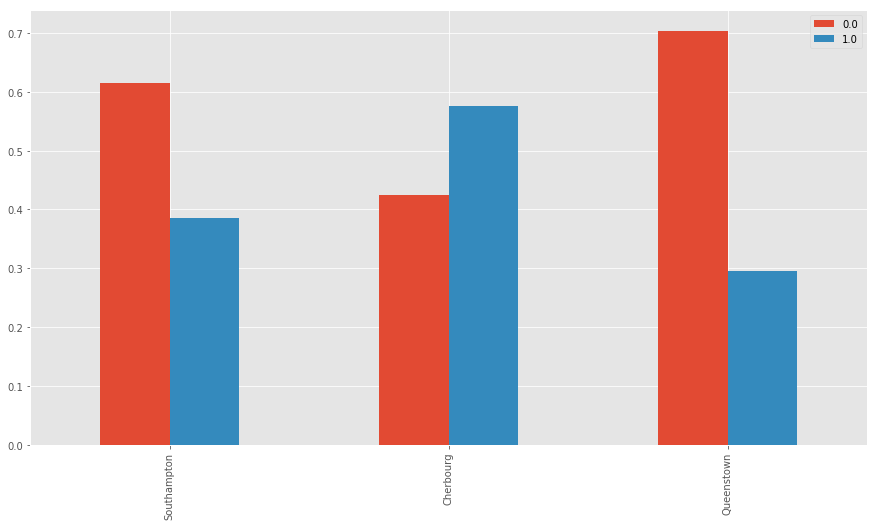

In [623]:
total_Embarked_S = data[data['embarked']=='S']['survived'].count()

total_Embarked_C = data[data['embarked']=='C']['survived'].count()

total_Embarked_Q = data[data['embarked']=='Q']['survived'].count()

Embarked_S = data[data['embarked']=='S']['survived'].value_counts() / total_Embarked_S

Embarked_C = data[data['embarked']=='C']['survived'].value_counts() / total_Embarked_C

Embarked_Q = data[data['embarked']=='Q']['survived'].value_counts() / total_Embarked_Q  

             

df = pd.DataFrame([Embarked_S,Embarked_C,Embarked_Q])

df.index = ['Southampton','Cherbourg','Queenstown']

df.plot(kind='bar',stacked=False, figsize=(15,8))



embarked與fare的關係

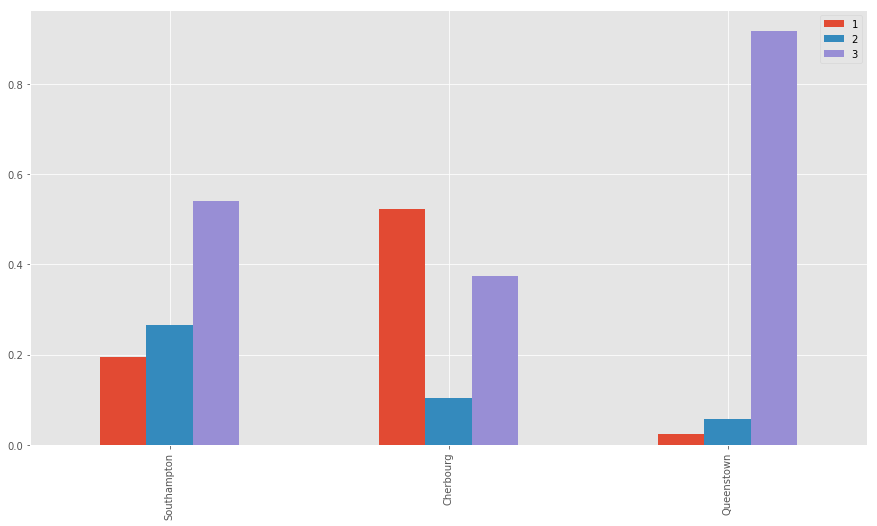

In [624]:
total_Pclass_S = data[data['embarked']=='S']['pclass'].count()

total_Pclass_C = data[data['embarked']=='C']['pclass'].count()

total_Pclass_Q= data[data['embarked']=='Q']['pclass'].count()

Embarked_S = data[data['embarked']=='S']['pclass'].value_counts() / total_Pclass_S

Embarked_C = data[data['embarked']=='C']['pclass'].value_counts() / total_Pclass_C

Embarked_Q = data[data['embarked']=='Q']['pclass'].value_counts() / total_Pclass_Q 

             

df = pd.DataFrame([Embarked_S,Embarked_C,Embarked_Q])

df.index = ['Southampton','Cherbourg','Queenstown']

df.plot(kind='bar',stacked=False, figsize=(15,8))


embarked有兩筆是缺失值，看看是哪兩筆

In [625]:
data.loc[(data.embarked.isnull())] 

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,family_size,title1
168,1,1.0,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,6,NaN,NaN,0,Miss
284,1,1.0,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,6,NaN,"Cincinatti, OH",0,Mrs


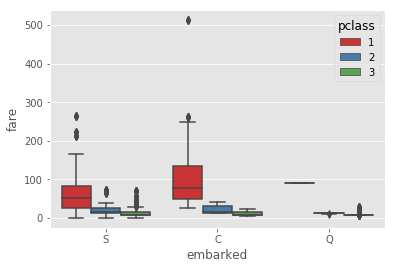

In [626]:
sns.boxplot(x="embarked",y="fare",hue="pclass",data=data,palette="Set1")

從Cherbourg港上岸的，有較大的比例為P1等級的船票，剛好缺失embarked的這兩位乘客的船票等級（Pclass）都是1，所以我們就直接假設她們的上岸港口為Cherbourg。

In [627]:
def fill_Embarked():
    data['embarked'].fillna("C", inplace=True)

In [628]:
fill_Embarked()

3.fare欄位

fare有缺失值，看看是哪一筆

In [629]:
data.loc[(data.fare.isnull())] 

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,family_size,title1
1225,3,NaN,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,NaN,261.0,NaN,0,Mr


我們直接用中位數來填入，因為從前面的分析中，很難確定Fare與何種欄位相關。

In [630]:
def fill_Fare():
      data['fare'].fillna(data['fare'].median(), inplace=True)
fill_Fare()

回顧非數值的欄位

In [631]:
data.describe(include=['O'])

,name,sex,ticket,cabin,embarked,boat,home.dest,title1
count,1309,1309,1309,295,1309,486,745,1309
unique,1307,2,929,186,3,27,369,18
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S,13,"New York, NY",Mr
freq,2,843,11,6,914,39,64,757


In [632]:
def fill_Ticket():

    global data

    data['ticket'] = data['ticket'].str.extract('([a-zA-Z]*)', expand=False).str.upper()

fill_Ticket()


In [633]:
data.describe(include=['O'])

,name,sex,ticket,cabin,embarked,boat,home.dest,title1
count,1309,1309,1309,295,1309,486,745,1309
unique,1307,2,21,186,3,27,369,18
top,"Kelly, Mr. James",male,,C23 C25 C27,S,13,"New York, NY",Mr
freq,2,843,957,6,914,39,64,757


4.處理name，並新增到title2

In [634]:
data['title2'] = data['title1'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','the Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
         ['Miss','Mrs','Miss','Mr','Mr','Mrs','Mrs','Mr','Mr','Mr','Mr','Mr','Mr','Mrs'])

In [635]:
data['title2'].unique()

array(['Miss', 'Master', 'Mr', 'Mrs'], dtype=object)

One-Hot Encoding：

最後須將所有即非數值Categories型態欄位進行One-Hot Encoding，才能送給機器進行學習。
這些屬於類別型態的欄位有：Sex、Pclass、Ticket、Embarked、Title2。



In [636]:
def oneHotEncode():

    global data
    data['sex'] = data['sex'].astype('category').cat.codes
    data['embarked'] = data['embarked'].astype('category').cat.codes
    data['pclass'] = data['pclass'].astype('category').cat.codes
    data['ticket'] = data['ticket'].astype('category').cat.codes
    data['title2'] = data['title2'].astype('category').cat.codes
oneHotEncode()

In [637]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,family_size,title1,title2
0,0,1.0,"Allen, Miss. Elisabeth Walton",0,29.0000,0,0,0,211.3375,B5,2,2,NaN,"St Louis, MO",0,Miss,1
1,0,1.0,"Allison, Master. Hudson Trevor",1,0.9167,1,2,0,151.5500,C22 C26,2,11,NaN,"Montreal, PQ / Chesterville, ON",3,Master,0
2,0,0.0,"Allison, Miss. Helen Loraine",0,2.0000,1,2,0,151.5500,C22 C26,2,NaN,NaN,"Montreal, PQ / Chesterville, ON",3,Miss,1
3,0,0.0,"Allison, Mr. Hudson Joshua Creighton",1,30.0000,1,2,0,151.5500,C22 C26,2,NaN,135.0,"Montreal, PQ / Chesterville, ON",3,Mr,2
4,0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0,25.0000,1,2,0,151.5500,C22 C26,2,NaN,NaN,"Montreal, PQ / Chesterville, ON",3,Mrs,3


##  建立模型與訓練

在開始訓練之前，記得將被合併到Train dataset的Test dataset再搬出來。

In [638]:
data = data.drop("name", axis=1)
data = data.drop("body", axis=1)
data = data.drop("home.dest", axis=1)
data = data.drop("boat", axis=1)
data = data.drop("title1", axis=1)
data = data.drop("cabin", axis=1)


X_train = data.iloc[:1000].drop("survived", axis=1)
Y_train = data.iloc[:1000]["survived"]
X_test  = data.iloc[1000:]
X_test = X_test.drop("survived",axis=1)

X_train.shape, Y_train.shape, X_test.shape


# X_train = X_train.drop(“Survived", axis=1)

# X_test = X_train.iloc[891:]

# X_train = X_train.head(891)

# X_train.shape, Y_train.shape, X_test.shape




((1000, 10), (1000,), (309, 10))

載入scikit-learn相關模組

In [639]:
# machine learning

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC, LinearSVC

from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import Perceptron

from sklearn.linear_model import SGDClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics, cross_validation



Logistic Regression

In [640]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log



79.0

Support Vector Machines

In [641]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

90.3

KNN

In [642]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

81.9

Decision Tree

In [643]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree


98.4

Random Forest

In [644]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

98.4

In [645]:
test.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,3,NaN,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.7500,NaN,Q,NaN,NaN,NaN
1,3,NaN,"McCoy, Miss. Agnes",female,NaN,2,0,367226,23.2500,NaN,Q,16,NaN,NaN
2,3,NaN,"McCoy, Miss. Alicia",female,NaN,2,0,367226,23.2500,NaN,Q,16,NaN,NaN
3,3,NaN,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,NaN,Q,16,NaN,NaN
4,3,NaN,"McDermott, Miss. Brigdet Delia",female,NaN,0,0,330932,7.7875,NaN,Q,13,NaN,NaN


In [646]:
submission = pd.DataFrame({
        "Name": test["name"],
        "Survived": Y_pred
    })

In [649]:
submission.to_csv('Titanic-submission.csv', index=False)